# Ajedrez


## Introducción  

¡Hola! En este notebook continuaremos con el desarrollo del proyecto basado en partidas de ajedrez. En el Colab anterior, realizamos la obtención, análisis y filtrado de un extenso dataset de más de 1 millones de partidas, optimizándolo para poder trabajar con datos más manejables y significativos.

En este notebook, utilizaremos el dataset previamente filtrado y procesado para avanzar en las siguientes etapas del proyecto:

* Generación del embedding personalizado:  Diseñaremos un embedding propio para representar los movimientos de ajedrez en notación algebraica, capturando patrones y relaciones entre las jugadas.

* Creación de la red neuronal recurrente (RNN):  Construiremos una RNN para predecir la siguiente jugada en una partida, basándonos en una secuencia de movimientos previos.

* Entrenamiento y evaluación del modelo:  Entrenaremos la RNN utilizando los embeddings generados y evaluaremos su capacidad para realizar predicciones precisas.

Este Colab ha sido configurado para aprovechar al máximo los recursos disponibles, como la RAM y la GPU, lo que permitirá un procesamiento más eficiente de los datos y la ejecución fluida del modelo.

## Subida de dataset

Importamos librerias necesarias para subir nuestro dataset y manipularlo

In [ ]:
import pandas as pd
import numpy as np

Creamos nuestro entorno de google drive para traer el datasets previamente construido en el colab anterior

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ruta del archivo en el drive

In [ ]:
dataset_path = '/content/drive/MyDrive/CoderHouse/Modulo 3/movimientos_tokenizados.csv'
df = pd.read_csv(dataset_path)

Observamos el dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999940 entries, 0 to 999939
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   movetext  999940 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


## Embedding

Para este proyecto vamos a utilizar Word2Vec, no es lo mejor ya que no tiene relacion con ajedrez y esta asociado a semantica de palabras en espacios vectoriales densos, pero entrenar un embedding propio por motivmos de tiempo y recursos no seria lo mejor, ademas word2vec ya cuenta con un entrenamiento y aprendio representaciones vectoriales para un gran numero de palabras, lo cual es beneficioso para nuestro dataset.

Esto igualmente implica hacerle un ajuste fino (fine-tuning) al modelo previamente entrenado.

¿Que ganamos?
* Aprovechamos conocimiento previo
* Reducimos el tiempo de entrenamiento
* Mejoramos el rendimiento en tareas

_____________________________________________________________________________________________________________________________

Importamos librerias necesarias

In [ ]:
from gensim.models import Word2Vec
import ast

Tokenizamos y preparamos las jugadas

In [ ]:
# Tokenizar y preparar las jugadas como listas de tokens
movements = df['movetext'].apply(ast.literal_eval).tolist()

Configuramos los parametros de aprendizaje


In [ ]:
# Configurar y entrenar el modelo Word2Vec
model = Word2Vec(sentences=movements, vector_size=300, window=5, min_count=1, sg=1)

# Guardar el modelo entrenado
model.save("chess_300d_word2vec.model")

### Analisis de los resultados

Primero veremos como el modelo ventoriza cada tokens en 300 dimensiones.

In [ ]:
print(model.wv['d4'])  # Vector para la jugada 'e4'

[ 1.55884221e-01  2.14495733e-01 -4.16624516e-01  3.10510814e-01
 -5.90255782e-02 -1.67143896e-01 -6.42140135e-02  2.41592571e-01
  2.34028753e-02 -1.92641914e-01 -1.87487185e-01  1.71993896e-02
  9.94568169e-02 -4.65300120e-02 -1.00564651e-01  1.55382991e-01
  1.83009416e-01  4.11085226e-02 -9.65168625e-02 -1.56795174e-01
  6.50711134e-02 -5.38799584e-01  3.76040004e-02  2.38192026e-02
  5.15927792e-01  2.25542471e-01 -1.74033388e-01 -1.16109535e-01
  1.70966789e-01  2.29315814e-02  1.28429495e-02  2.99226850e-01
  2.38836296e-02 -2.52552956e-01 -4.25026476e-01 -3.88655253e-02
  2.52667487e-01 -2.57914960e-01 -1.04162246e-01  2.22642347e-01
  2.53801376e-01 -2.13778704e-01 -2.11777583e-01 -8.67338479e-02
 -2.10058708e-02  2.13656247e-01  3.25921506e-01  1.08151086e-01
  1.37889594e-01 -1.04118645e-01  1.54668823e-01 -3.43102105e-02
  2.04121619e-02  3.83823365e-01  1.52958423e-01  4.64564636e-02
  1.64684176e-01  8.33305418e-02  1.75737347e-02 -6.96000531e-02
 -1.24013312e-01  2.19604

Ya viendo que el modelo genero bien loz vectores en un espacio vectorial denso, podemos hacer calculos para analizar relaciones en las jugadas de ajedrez.

In [ ]:
# Jugadas más similares a 'e4'
similar_moves = model.wv.most_similar('e4', topn=5)
print("Jugadas más similares a 'e4':", similar_moves)

Jugadas más similares a 'e4': [('Nf6', 0.47968465089797974), ('d4', 0.4632032811641693), ('d5', 0.46247994899749756), ('Nf3', 0.45295029878616333), ('e3', 0.438298761844635)]


Como vemos aca usamos algunos filtros que trae el modelo para buscar las jugadas mas similares, pero en este caso como ya no son jugadas y son tokens en un espacio vectorial denso, lo que hacemos es buscar los vectores mas proximos a otros.

Y si a esto lo trasladamos al ajedrez vemos que nuestro embedding pudo capturar bastante bien las relaciones sin tener algun tipo de idea de reglas o movimientos.

Ya que buscamos jugadas similares a **e4**, y el modelo nos devolvio:
* d4
* d5
* Nf6

Las tres jugadas e4, d4 y d5 son movimientos de peones hacia el centro.
Y la siguiente Nf6 es un movimiento de caballo usualmente usado por las negras para controlar el avanze de los peones.

A continuacion para que esto sea aun mas grafico veremos estas jugadas en un tablero de ajedrez

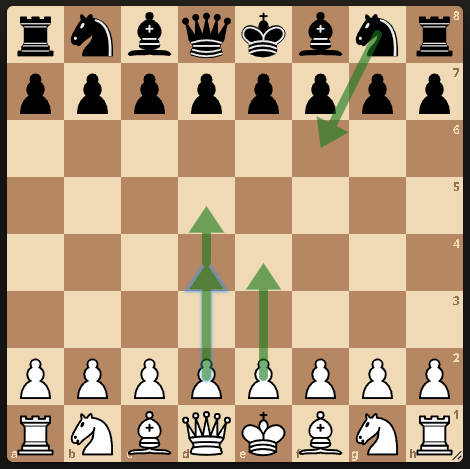

Como vemos el modelo para la jugada inicial e4 entiende bastante bien en su espacio vectorial que las jugadas mas simialres serian d4 y luego d5.

O contrariamente una posicion de defensa para las negras Nf6

### Reduccion de la dimensionalidad

A continuacion para comprender o tratar de sacar algunos insight vamos a utilizar t-SNE, para reducir la dimesionalidad de nuestro embedding de 300 a 2, esto se hace simplemente para poder ver de manera grafica algunos posibles patrones, pero tenemos que tener en cuenta que en el proceso de reduccion es posible que se pierda informacion relevante e igualmente sea dificil encontrar patrones de jugadas, sobre todo ya que es algo complejo de vectortizar.

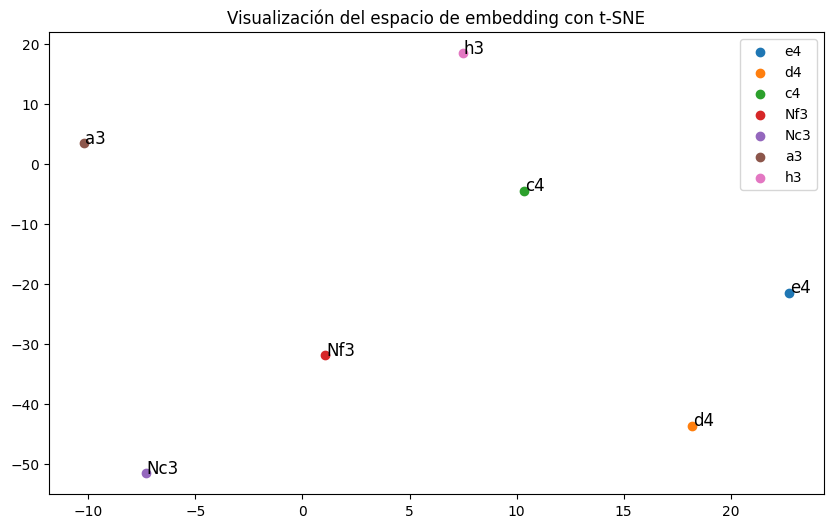

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Palabras (movimientos) a analizar
words = ['e4', 'd4', 'c4', 'Nf3', 'Nc3', 'a3', 'h3']
vectors = np.array([model.wv[word] for word in words])  # Convertir a numpy array

# Reducir a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, perplexity=5, max_iter=300, random_state=42)  # n_iter cambiado a max_iter
reduced_vectors = tsne.fit_transform(vectors)

# Graficar
plt.figure(figsize=(10, 6))
for word, (x, y) in zip(words, reduced_vectors):
    plt.scatter(x, y, label=word)
    plt.text(x + 0.05, y + 0.05, word, fontsize=12)

plt.title("Visualización del espacio de embedding con t-SNE")
plt.legend()
plt.show()


Igualmente del grafico podemos sacar informacion valiosa.

Como vemos tenemos algunos grupos de puntos mas cercanos.

* e4 y d4 : Como  se observa comparten ciertas distancias en este espacio bidimensional, esto tiene mucho sentido ya que son movimientos de peones hacia el centro y son bastante similares en cuanto a uso y disposicion en el tablero.
* Nc3 y Nf3: Como se observa estos movimientos tambien poseen una cercania relativa, ya que son movimientos de caballo en una misma fila, como se pueden usar en aperturas o defensas.
* Luego tenemos puntos mas dispersos como a3 y h3, esto tiene logica ya que son movimientos de peones pero de filas comlpetamente opuestas.

Para dejar mas en claro los grupos de movimientos vamos a mostrar en tablero que movimientos serian

Movimientos e4 y d4

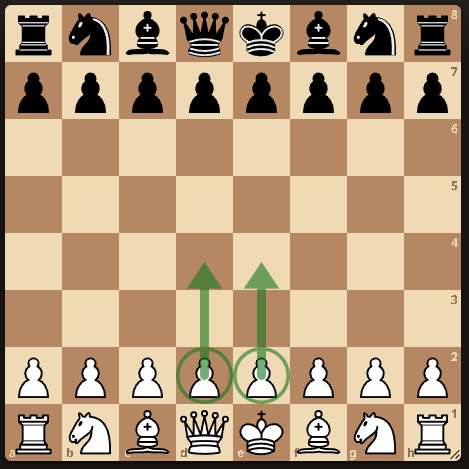

Movimientos Nc3 y Nf3

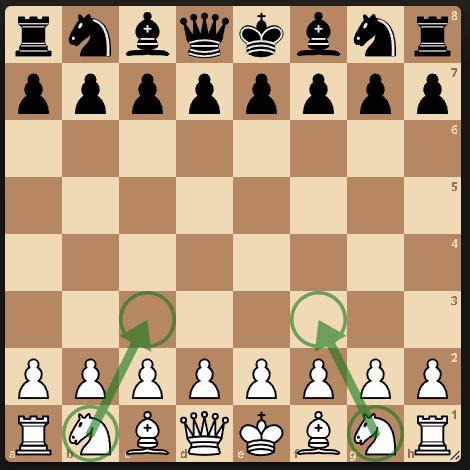

## Red Neuronal Recurrente

### ¡Aclaraciones!

Como contamos con una limitada capacidad de computo, previamente a construir y entrenar la RNN, vamos a descargar el Embedding para poder subirlo por si la sesion se reinicia o nos quedamos sin Ram.

Esta aclaracion es importante ya que van a ver que el codigo cuenta con descargas y cargas del Embedding

**¡ Si es necesario recargar el embedding !**

In [ ]:
from gensim.models import Word2Vec

# Ruta del archivo en Google Drive
model_path = "/content/drive/MyDrive/CoderHouse/Modulo 3/chess_300d_word2vec.model"

# Cargar el modelo desde la ruta
model = Word2Vec.load(model_path)

Verificamos el embedding cargado

In [ ]:
# Verificar que está cargado correctamente
print(model.wv['e4'])

[ 0.28666908  0.2546868  -0.1237541   0.36892128 -0.11730305  0.09891408
  0.3244032  -0.08331809  0.09328224 -0.00617075 -0.12839675  0.00663685
 -0.02508658 -0.02901901 -0.07907159  0.13013913 -0.001739    0.07328736
  0.03297682 -0.17113188  0.257501   -0.42770812 -0.12586306  0.12422668
  0.06060028  0.34592316  0.12985149  0.07887073  0.06806964 -0.15738526
  0.0239807   0.23936424  0.24730611  0.08735652 -0.06840134  0.01512835
  0.03324372 -0.20949458 -0.1179867   0.20293039  0.07003862 -0.3482624
 -0.12362567 -0.0954475   0.18504955  0.05480314  0.01852699  0.08665677
  0.08082818 -0.09147584 -0.11832173  0.09620705  0.02487501  0.26893276
 -0.26071653  0.02004053  0.01903075 -0.09618666  0.08665172 -0.00329943
 -0.03993351  0.1921916  -0.12917817 -0.03291308  0.30394408  0.05220265
 -0.0365791   0.23910506  0.08554762 -0.01289923  0.13909258 -0.12751545
  0.03817552 -0.3104974  -0.01664471 -0.04637084 -0.10787294  0.02370929
 -0.15474993  0.1465673   0.22309874 -0.15516154  0.

### Construccion y entrenamiento

####  Preparamos los datos para el entrenamiento

Importamos librerias necearias

In [ ]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

Tokenización y asignación de índices

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Convertir movements a una lista de cadenas de texto
movements_text = [' '.join(move) for move in movements]

# Inicializar el tokenizador
tokenizer = Tokenizer(filters='', lower=False)
tokenizer.fit_on_texts(movements_text)  # Usar movements_text en lugar de df['movetext']

# Convertir los movimientos a secuencias de índices
sequences = tokenizer.texts_to_sequences(movements_text)

# Guardar el tamaño del vocabulario
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulario: {vocab_size} palabras únicas")


Vocabulario: 11610 palabras únicas


Verificamos la consistencia de la tokenizacion

In [ ]:
# Vocabulario del tokenizador
vocab_tokenizer = set(tokenizer.word_index.keys())

# Cargar el modelo preentrenado
embedding_model = Word2Vec.load('/content/drive/MyDrive/CoderHouse/Modulo 3/chess_300d_word2vec.model')
print(f"Vocabulario cargado: {len(embedding_model.wv)} palabras únicas.")

# Vocabulario de Word2Vec
vocab_word2vec = set(embedding_model.wv.key_to_index.keys())

# Palabras en el tokenizador pero no en Word2Vec
palabras_faltantes = vocab_tokenizer - vocab_word2vec
print(f"Palabras en el tokenizador pero no en Word2Vec: {len(palabras_faltantes)}")
print(f"Ejemplo de palabras faltantes: {list(palabras_faltantes)[:10]}")

Vocabulario cargado: 11609 palabras únicas.
Palabras en el tokenizador pero no en Word2Vec: 0
Ejemplo de palabras faltantes: []


Crear secuencias de entrada y salida para la RNN

In [ ]:
def generate_batches(sequences, batch_size=10000, max_sequence_length=None):
    """
    Generador que crea lotes de secuencias y etiquetas sin cargar todo en memoria.
    Añadimos padding para asegurar que todas las secuencias tienen la misma longitud.
    """
    input_sequences = []
    output_labels = []

    # Determinamos la longitud máxima si no se pasa como argumento
    if max_sequence_length is None:
        max_sequence_length = max(len(sequence) for sequence in sequences)

    for sequence in sequences:
        for i in range(1, len(sequence)):
            input_sequences.append(sequence[:i])
            output_labels.append(sequence[i])

            # Si hemos alcanzado el tamaño del batch, lo devolvemos
            if len(input_sequences) >= batch_size:
                # Hacer padding a las secuencias de entrada para que tengan la misma longitud
                input_sequences_padded = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
                yield np.array(input_sequences_padded), np.array(output_labels)
                input_sequences = []  # Limpiar para el siguiente lote
                output_labels = []

    # Devolver cualquier secuencia restante que no haya alcanzado el tamaño del batch
    if input_sequences:
        input_sequences_padded = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
        yield np.array(input_sequences_padded), np.array(output_labels)

# Usar el generador
batch_size = 10000  # Ajusta el tamaño del lote según tus necesidades
max_sequence_length = 50  # Aquí defines la longitud máxima de las secuencias (ajústalo según sea necesario)

for X_batch, y_batch in generate_batches(sequences, batch_size, max_sequence_length):
    # Aquí puedes usar X_batch y y_batch para entrenar tu modelo
    print(f"Lote de secuencias X: {X_batch.shape}, Lote de etiquetas y: {y_batch.shape}")


Se truncaron las últimas líneas 5000 del resultado de transmisión.
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (10000, 50), Lote de etiquetas y: (10000,)
Lote de secuencias X: (

#### Creamos la matriz de embeddings

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Cargar el modelo preentrenado
embedding_model = Word2Vec.load('/content/drive/MyDrive/CoderHouse/Modulo 3/chess_300d_word2vec.model')
print(f"Vocabulario cargado: {len(embedding_model.wv)} palabras únicas.")

# Inicializamos la matriz de embeddings con ceros
embedding_dim = 300  # Dimensión del embedding (300 en tu caso)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Llenamos la matriz con los vectores de Word2Vec
for word, index in tokenizer.word_index.items():
    if word in embedding_model.wv:
        embedding_matrix[index] = embedding_model.wv[word]  # Usar el vector de Word2Vec
    else:
        # Asignar un vector aleatorio para palabras desconocidas
        embedding_matrix[index] = np.random.rand(embedding_dim)

# Verifica que la matriz tiene la forma correcta
print(f"Matriz de embeddings generada de tamaño: {embedding_matrix.shape}")


Vocabulario cargado: 11609 palabras únicas.
Matriz de embeddings generada de tamaño: (11610, 300)


Verificamos el token de padding

In [ ]:
# Verificar el vector de padding (índice 0)
print("Vector de padding (índice 0):", embedding_matrix[0])

Vector de padding (índice 0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Verificar el vector de una palabra conocida (por ejemplo, 'e4')
word = 'e4'
index = tokenizer.word_index[word]
print(f"Vector para '{word}' (índice {index}):", embedding_matrix[index])

Vector para 'e4' (índice 5): [ 0.28666908  0.2546868  -0.1237541   0.36892128 -0.11730305  0.09891408
  0.3244032  -0.08331809  0.09328224 -0.00617075 -0.12839675  0.00663685
 -0.02508658 -0.02901901 -0.07907159  0.13013913 -0.001739    0.07328736
  0.03297682 -0.17113188  0.25750101 -0.42770812 -0.12586306  0.12422668
  0.06060028  0.34592316  0.12985149  0.07887073  0.06806964 -0.15738526
  0.0239807   0.23936424  0.24730611  0.08735652 -0.06840134  0.01512835
  0.03324372 -0.20949458 -0.1179867   0.20293039  0.07003862 -0.3482624
 -0.12362567 -0.0954475   0.18504955  0.05480314  0.01852699  0.08665677
  0.08082818 -0.09147584 -0.11832173  0.09620705  0.02487501  0.26893276
 -0.26071653  0.02004053  0.01903075 -0.09618666  0.08665172 -0.00329943
 -0.03993351  0.1921916  -0.12917817 -0.03291308  0.30394408  0.05220265
 -0.0365791   0.23910506  0.08554762 -0.01289923  0.13909258 -0.12751545
  0.03817552 -0.3104974  -0.01664471 -0.04637084 -0.10787294  0.02370929
 -0.15474993  0.1465673

#### Descargamos complementos previamente creadas

Esto de descargar los archivos necesarios para la red neuronal lo hacemos como medida preventiva, en caso de que la sesión falle por falta de RAM o sea insuficiente para entrenar la red neuronal.

##### Descargamos componenentes necesarios

Guardamos el embedding

In [ ]:
from gensim.models import Word2Vec

# Guardar el modelo de Word2Vec en Google Drive
embedding_model.save("/content/drive/MyDrive/CoderHouse/Modulo 3/chess_300d_word2vec.model")

Guardamos la matriz de embedding

In [ ]:
import numpy as np

# Guardar la matriz de embedding en Google Drive
np.save("/content/drive/MyDrive/CoderHouse/Modulo 3/embedding_matrix.npy", embedding_matrix)

Guardamos las secuencias tokenizadas

In [ ]:
import pickle

# Guardar las secuencias tokenizadas en Google Drive
with open("/content/drive/MyDrive/CoderHouse/Modulo 3/sequences.pkl", "wb") as f:
    pickle.dump(sequences, f)

Guardamos el tokenizador

In [ ]:
import pickle

# Guardar el tokenizador en Google Drive
with open("/content/drive/MyDrive/CoderHouse/Modulo 3/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

#### Cargamos complementos previamente creadas

Montamos google drive para poder acceder a los contenidos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos el embedding

In [ ]:
from gensim.models import Word2Vec

# Cargar el modelo de Word2Vec desde Google Drive
embedding_model = Word2Vec.load("/content/drive/MyDrive/CoderHouse/Modulo 3/chess_300d_word2vec.model")

Cargamos la Matriz de Embedding

In [ ]:
import numpy as np

# Cargar la matriz de embedding desde Google Drive
embedding_matrix = np.load("/content/drive/MyDrive/CoderHouse/Modulo 3/embedding_matrix.npy")

Cargamos las Secuencias Tokenizadas

In [ ]:
import pickle

# Cargar las secuencias tokenizadas desde Google Drive
with open("/content/drive/MyDrive/CoderHouse/Modulo 3/sequences.pkl", "rb") as f:
    sequences = pickle.load(f)

Cargamos el Tokenizador

In [ ]:
import pickle

# Cargar el tokenizador desde Google Drive
with open("/content/drive/MyDrive/CoderHouse/Modulo 3/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

Funcion generadora de batches

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_batches(sequences, batch_size=10000, max_sequence_length=None):
    input_sequences = []
    output_labels = []

    if max_sequence_length is None:
        max_sequence_length = max(len(sequence) for sequence in sequences)

    for sequence in sequences:
        for i in range(1, len(sequence)):
            input_sequences.append(sequence[:i])
            output_labels.append(sequence[i])

            if len(input_sequences) >= batch_size:
                input_sequences_padded = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
                yield np.array(input_sequences_padded), np.array(output_labels)
                input_sequences = []
                output_labels = []

    if input_sequences:
        input_sequences_padded = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
        yield np.array(input_sequences_padded), np.array(output_labels)

#### Crear la red neuronal

Antes de crear la RNN, vamos a definir los hiperparametros de los componentes cargados anteriormente

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Tamaño del vocabulario
embedding_dim = 300  # Dimensión del embedding
max_sequence_length = 50  # Longitud máxima de las secuencias

Ya teniendo la matriz de embeddings, la usaremos en nuestra capa de Ebedding.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Crear el modelo
model = Sequential()

# Capa de embedding: Usamos el embedding preentrenado de Word2Vec
model.add(Embedding(
    input_dim=vocab_size,          # Tamaño del vocabulario
    output_dim=embedding_dim,      # Dimensiones del embedding
    weights=[embedding_matrix],    # Usamos la matriz de embedding que preparamos antes
    trainable=True                 # Permitir que el embedding se ajuste durante el entrenamiento
))

# Primera capa LSTM con regularización L2
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Segunda capa LSTM con regularización L2
model.add(LSTM(128, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Capa densa para la predicción final
model.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo con una tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       3,483,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,483,000 (13.29 MB)

 Trainable params: 3,483,000 (13.29 MB)

 Non-trainable params: 0 (0.00 B)

Compilamos

In [ ]:
# Compilar el modelo
model.compile(
    optimizer='adam',                 # Puedes ajustar el optimizador si lo deseas
    loss='sparse_categorical_crossentropy',  # Pérdida para clasificación multiclase
    metrics=['accuracy']             # Métrica para evaluar
)

print("Modelo compilado correctamente.")


Modelo compilado correctamente.


#### Entrenamiento

Entrenamos el modelo

In [ ]:
from keras.callbacks import EarlyStopping

# Parámetros de entrenamiento
epochs = 5  # Número de épocas
batch_size = 10000  # Tamaño del lote para generar datos
mini_batch_size = 128  # Tamaño del mini-batch para entrenar dentro de cada lote
max_sequence_length = 50  # Longitud máxima de las secuencias

# Callback para detener el entrenamiento si no mejora
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Entrenamiento
for epoch in range(epochs):
    print(f"\nÉpoca {epoch + 1}/{epochs}")

    # Contador para mostrar el progreso dentro de la época
    batch_counter = 0

    for X_batch, y_batch in generate_batches(sequences, batch_size=batch_size, max_sequence_length=max_sequence_length):
        # Entrenar con el lote actual usando train_on_batch
        loss, accuracy = model.train_on_batch(X_batch, y_batch)

        # Mostrar el progreso
        batch_counter += 1
        print(f"Lote {batch_counter}: Pérdida = {loss:.4f}, Precisión = {accuracy:.4f}")

    print(f"Época {epoch + 1} completada.")

    # Verificar si se debe detener el entrenamiento (early stopping)
    if early_stopping.model is not None and early_stopping.stopped_epoch > 0:
        print("Entrenamiento detenido por early stopping.")
        break


Época 1/5
Lote 1: Pérdida = 15.1847, Precisión = 0.0002
Lote 2: Pérdida = 15.0862, Precisión = 0.0025
Lote 3: Pérdida = 14.9876, Precisión = 0.0071
Lote 4: Pérdida = 14.8878, Precisión = 0.0099


Lote 5: Pérdida = 14.7860, Precisión = 0.0115


Lote 6: Pérdida = 14.6808, Precisión = 0.0128
Lote 7: Pérdida = 14.5721, Precisión = 0.0133
Lote 8: Pérdida = 14.4566, Precisión = 0.0133
Lote 9: Pérdida = 14.3347, Precisión = 0.0134
Lote 10: Pérdida = 14.2062, Precisión = 0.0136
Lote 11: Pérdida = 14.0727, Precisión = 0.0138
Lote 12: Pérdida = 13.9361, Precisión = 0.0138
Lote 13: Pérdida = 13.7963, Precisión = 0.0138
Lote 14: Pérdida = 13.6534, Precisión = 0.0139
Lote 15: Pérdida = 13.5091, Precisión = 0.0139
Lote 16: Pérdida = 13.3621, Precisión = 0.0141
Lote 17: Pérdida = 13.2163, Precisión = 0.0141
Lote 18: Pérdida = 13.0694, Precisión = 0.0142
Lote 19: Pérdida = 12.9242, Precisión = 0.0143
Lote 20: Pérdida = 12.7809, Precisión = 0.0144
Lote 21: Pérdida = 12.6403, Precisión = 0.0145
Lote 22: Pérdida = 12.5034, Precisión = 0.0146
Lote 23: Pérdida = 12.3692, Precisión = 0.0148
Lote 24: Pérdida = 12.2388, Precisión = 0.0149
Lote 25: Pérdida = 12.1126, Precisión = 0.0151
Lote 26: Pérdida = 11.9909, Precisión = 0.0153
Lote 27: Pérdida 

In [ ]:
# Finalizar y guardar el modelo
model.save("/content/drive/My Drive/chess_lstm_model.h5")
print("Modelo guardado.")


## Conclusión

Aunque no llegamos a ejecutar y probar completamente la red neuronal recurrente (RNN), este proyecto ha sido una experiencia increíblemente enriquecedora y llena de aprendizajes. Uno de los mayores logros fue superar el desafío inicial de trabajar con un dataset tan grande, algo que al principio parecía casi imposible. Conseguimos filtrar y analizar los datos con técnicas tradicionales y de NLP, lo que ya es un gran avance.

Poder crear mi propio embedding fue una de las partes más fascinantes del proyecto. Ver cómo un modelo puede entender patrones y sacar contexto a partir de simples vectores fue simplemente mágico. También logramos desarrollar todos los módulos necesarios para la red neuronal: tokenizamos las jugadas, creamos las secuencias, organizamos los batches y estructuramos la red completa.

A pesar de las limitaciones del entorno de Google Colab, como la falta de RAM que dificultó los entrenamientos y causó fallos en las sesiones, cada pequeño obstáculo fue una oportunidad para aprender y crecer. Ahora entiendo mejor los desafíos técnicos, pero también las infinitas posibilidades que ofrece la inteligencia artificial aplicada al ajedrez.

Este proyecto me deja con una sensación de orgullo y felicidad. No solo por los objetivos alcanzados, sino porque representa el inicio de algo mucho más grande. He aprendido muchísimo, no solo sobre datos y modelos, sino también sobre cómo enfrentar problemas complejos con creatividad y perseverancia.

Esto no termina aquí. Me voy con la confianza de que puedo mejorar aún más, de que puedo seguir explorando este fascinante mundo del ajedrez y la inteligencia artificial. Estoy emocionado por todo lo que vendrá y feliz de haber dado este gran paso.

Aunque no todo resultó como esperaba, la última vez que logré ejecutar la red neuronal pude observar avances prometedores. Durante el entrenamiento, la pérdida comenzó a disminuir gradualmente y la precisión mostró un ligero pero constante aumento, lo que evidencia que la red estaba aprendiendo de los datos. Por ejemplo, en los primeros lotes de una de las pruebas, la pérdida bajó de 15.18 a 10.32, mientras que la precisión incrementó de 0.0002 a 0.0174. Estos resultados, aunque preliminares, demuestran que el modelo tiene potencial y que, con ajustes en los parámetros y un entorno más robusto, se podrían obtener mejores resultados. Este pequeño avance reafirma que estoy en el camino correcto y me motiva a seguir trabajando en este proyecto para superar los desafíos pendientes y alcanzar los objetivos planteados.



Desde ya muchas gracias a Coderhouse y sobre todo a aquellas personas que me ayudaron a aprender y sumergirme mas en el mundo de la ciencia de datos.

Muchas gracias a mi profesor **Fernando Carabedo** que en cada clase desde Data Science 2 hasta Data Science 3, estuvo alli enseñandonos y mostrando lo magico de este mundo de la ciencia de datos, y lo apasionante que puede llegar a ser, me contagio mucho las ganas de seguir aprendiendo y ver como esto tiene un impacto significativamente grande en el dia a dia.

Por otro lado un enorme agradecimiento al Tutor **Carlos Davoli**, que fue mi tutor en varios cursos, en este ultimo no pero era uno de los tutores del curso, y a pesar de no estar bajo su responsabilidad cada vez que necesite ayuda estuvo alli aconsejandome y guiandome de como podia llegar a hacer las cosas.

Asi mismo un agradecimiento al tutor del ultimo curso del cual es este proyecto **Giuliano Crenna**, que en cada clase aportaba con su conocimiento y luego ante cualquier duda era el primero en contestar.

Tambien agradecer al sitio
[Lichess.org](https://lichess.org/es)
que sin sus datos nada de esto hubiese sido posible

Muchas gracias por tomarse el tiempo de leer y espero poder concretar este proyecto, ante cualquier actualizacion el codigo sera nuevamente subido a github con sus respectivos cambios.